In [1]:
import pandas as pd

# Load the data
data = data = pd.read_csv("C:/Users/admin/OneDrive/maytinh/Downloads/META_stock_data.csv") 

In [2]:
data['MA21'] = data['Close'].rolling(window=21).mean()

In [3]:
def calculate_rsi(data, window=21):
    delta = data.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

data['RSI'] = calculate_rsi(data['Close'])


In [4]:
data = data.dropna()  # Loại bỏ các hàng chứa giá trị NaN do tính RSI và MA

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 231 entries, 20 to 250
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          231 non-null    object 
 1   Open          231 non-null    float64
 2   High          231 non-null    float64
 3   Low           231 non-null    float64
 4   Close         231 non-null    float64
 5   Volume        231 non-null    int64  
 6   Dividends     231 non-null    float64
 7   Stock Splits  231 non-null    float64
 8   MA21          231 non-null    float64
 9   RSI           231 non-null    float64
dtypes: float64(8), int64(1), object(1)
memory usage: 19.9+ KB


In [6]:
import numpy as np

# Tính toán số lượng dòng cho từng phần
total_rows = len(data)
train_size = int(0.8 * total_rows)
val_size = int(0.1 * total_rows)
test_size = total_rows - train_size - val_size 
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(how='any', axis=0, inplace=True)

# Chia DataFrame thành các tập huấn luyện, kiểm tra và kiểm định
data_train = data.iloc[:train_size]
data_val = data.iloc[train_size:train_size + val_size]
data_test = data.iloc[train_size + val_size:]

In [7]:
from sklearn.preprocessing import MinMaxScaler
import warnings

pd.options.mode.chained_assignment = None 
# Chuẩn hóa các cột giá dựa trên tập huấn luyện và áp dụng cho tập kiểm tra và kiểm định
scaler_price = MinMaxScaler(feature_range=(-1, 1))
# price_columns = ['Close', 'Open', 'High', 'Low']
price_columns = ['Close', 'Open', 'High', 'Low','MA21','RSI']
data_train[price_columns] = scaler_price.fit_transform(data_train[price_columns])
data_val[price_columns] = scaler_price.transform(data_val[price_columns])
data_test_copy=data_test[price_columns]
data_test[price_columns] = scaler_price.transform(data_test[price_columns])
train_data = data_train[price_columns].values
val_data = data_val[price_columns].values
test_data = data_test[price_columns].values

# Hiển thị kích thước của các tập dữ liệu
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

Training data shape: (184, 6)
Validation data shape: (23, 6)
Test data shape: (24, 6)


In [68]:
# Training data
seq_len = 21
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i])
  y_train.append(train_data[:, 0][i]) 
X_train, y_train = np.array(X_train), np.array(y_train)



# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 0][i])
X_val, y_val = np.array(X_val), np.array(y_val)


# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 0][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (474, 21, 6) (474,)
Validation set shape (40, 21, 6) (40,)
Testing set shape (42, 21, 6) (42,)


In [69]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, GlobalAveragePooling1D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MultiHeadAttention

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_len, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(max_len, embed_dim)
    
    def get_angles(self, pos, i, embed_dim):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(embed_dim))
        return pos * angle_rates
    
    def positional_encoding(self, max_len, embed_dim):
        angle_rads = self.get_angles(np.arange(max_len)[:, np.newaxis],
                                     np.arange(embed_dim)[np.newaxis, :],
                                     embed_dim)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=True):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Thông số mô hình cơ bản
embed_dim = 64
num_heads = 4
ff_dim = 128
num_transformer_blocks = 1  # Số lượng Transformer blocks giảm xuống 1
max_len = 21
num_features = 6

# Đầu vào của Transformer
inputs = Input(shape=(max_len, num_features))
x = Dense(embed_dim)(inputs)
x = PositionalEncoding(max_len, embed_dim)(x)

# Xây dựng Transformer block
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss=tf.keras.losses.MeanAbsolutePercentageError())


In [70]:
import time

start_time = time.time()
# Bước 7: Huấn luyện mô hình
model.fit(X_train, y_train, epochs=40, batch_size=32, validation_split=0.2)
end_time = time.time()
training_time = end_time - start_time

Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 251.2964 - val_loss: 168.9427
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 204.4827 - val_loss: 16.1982
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 113.8436 - val_loss: 54.4455
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 130.4973 - val_loss: 94.8150
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 129.5609 - val_loss: 77.7303
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 147.8947 - val_loss: 12.6042
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 109.6063 - val_loss: 22.0386
Epoch 8/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 115.8014 - val_loss: 13.6580
Epoch 9/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 118.2167 - val_loss: 30.1544
Epoch 10/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 75.8993 - val_loss: 12.2741
Epoch 11/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 70.4570 - val_loss: 43.2757
Epoch 12/40
12/12 ━━━━━━━━━━━━━

In [71]:
# Predicting and reversing normalization
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler_price.inverse_transform(np.concatenate((predicted_stock_price, np.zeros((len(predicted_stock_price), 5))), axis=1))[:,0]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


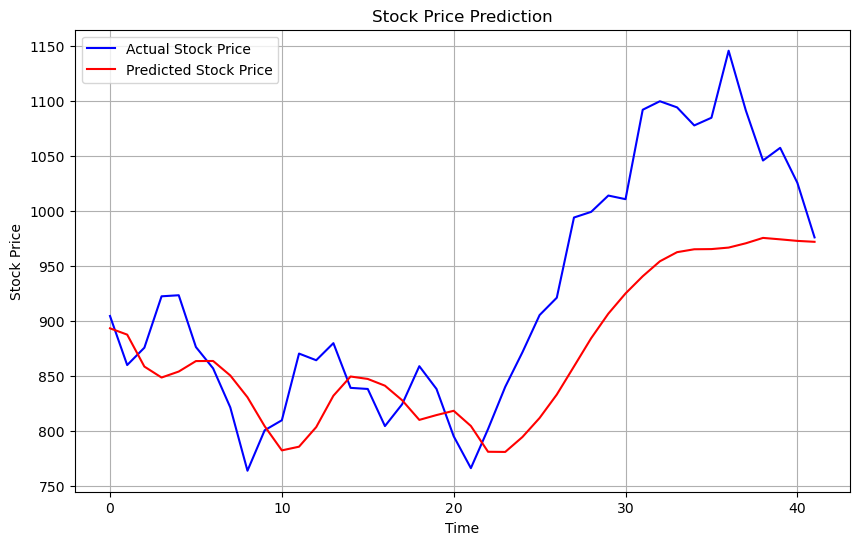

Root Mean Squared Error: 79.16451306618717
Mean Absolute Percentage Error: 0.06569304508894105
Thời gian training mô hình: 10.656384229660034


In [72]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Get actual prices from the last part of the test set
actual_prices = data_test_copy['Close'].values[seq_len:]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='blue', label='Actual Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Calculate RMSE
rmse = mean_squared_error(actual_prices, predicted_stock_price, squared=False)
print(f"Root Mean Squared Error: {rmse}")

mape = mean_absolute_percentage_error(actual_prices, predicted_stock_price)
print(f"Mean Absolute Percentage Error: {mape}")

print('Thời gian training mô hình:',training_time)